code citation:
https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb#scrollTo=FyRpvwENxE-A

In [ ]:
# pip install earthengine-api --upgrade

In [ ]:
# pip install geemap

**remember to re-auth every time you want to upload**

In [1]:
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1Adeu5BUQPQNHGztXz3y8vMWyMgJD6W0YfNmRZ0VbBMiKWFvq-4XEvlUBr2Y



Successfully saved authorization token.


In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import geemap
import folium

2023-08-10 22:50:23.110331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 22:50:27.037397: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-08-10 22:50:27.038361: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/

In [3]:
tf.config.run_functions_eagerly(True)

Define datasets

In [3]:
feature_list = []
# Fire label
# 2000-2023
# https://developers.google.com/earth-engine/datasets/catalog/FIRMS
fire_map_info = {'name':'FIRMS', 'band' :'T21', 'min': 300, 'max': 509.29}
# MODIS Normalized difference vegetation index NDVI dataset
# 2000-2023
# https://developers.google.com/earth-engine/datasets/catalog/MODIS_MOD09GA_006_NDVI
veg_map_info = {'name':'MODIS/MOD09GA_006_NDVI', 'band' :'NDVI', 'min': -1, 'max': 1}
feature_list.append(veg_map_info)
# MODIS Leaf Area Index/FPAR 4-Day Global 500m
# 2002-2023
# https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD15A3H
# upper limit is 20+, so set max = 30
leaf_map_info = {'name':'MODIS/061/MCD15A3H', 'band' :'Lai', 'min': 0, 'max': 30}
feature_list.append(leaf_map_info)
# FLDAS: Famine Early Warning Systems Network (FEWS NET) Land Data Assimilation System
# 1982-2023
# https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001
soil_moist_map_info = {'name':'NASA/FLDAS/NOAH01/C/GL/M/V001', 'band' :'SoilMoi00_10cm_tavg', 'min': 0, 'max': 1}
feature_list.append(soil_moist_map_info)
# Terra Land Surface Temperature and Emissivity Daily Global 1km
# 2000-2023
# https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD11A1
temp_map_info = {'name':'MODIS/061/MOD11A1', 'band' :'LST_Day_1km', 'min': 13658, 'max': 15658}
feature_list.append(temp_map_info)
# ERA5 Monthly Aggregates dataset
# 1979-2020
# https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_MONTHLY
precipitation_map_info = {'name':'ECMWF/ERA5/MONTHLY', 'band' :'total_precipitation', 'min': 0, 'max': 0.4}
feature_list.append(precipitation_map_info)
wind_speed_u_map_info = {'name':'ECMWF/ERA5/MONTHLY', 'band' :'u_component_of_wind_10m', 'min': -8.7, 'max': 8.7}
feature_list.append(wind_speed_u_map_info)
wind_speed_v_map_info = {'name':'ECMWF/ERA5/MONTHLY', 'band' :'v_component_of_wind_10m', 'min': -6.8, 'max': 6.8}
feature_list.append(wind_speed_v_map_info)

# Copernicus Global Land Cover Layers: CGLS-LC100 Collection 3
# 2015-end2019
# https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_Landcover_100m_Proba-V-C3_Global
land_cover_info = {'name':"COPERNICUS/Landcover/100m/Proba-V-C3/Global", 'band': 'discrete_classification', 'min': 0, 'max': 200}
# feature_list.append(wind_speed_v_map_info)
# print(feature_list)
print(len(feature_list))
print(type(feature_list))

7
<class 'list'>


Define label and feature bands

In [4]:
LABEL = fire_map_info['band']
BANDS = []
for feature in feature_list:
  BANDS += [feature['band']]
FEATURE_NAMES = BANDS + [LABEL]
print(FEATURE_NAMES)

['NDVI', 'Lai', 'SoilMoi00_10cm_tavg', 'LST_Day_1km', 'total_precipitation', 'u_component_of_wind_10m', 'v_component_of_wind_10m', 'T21']


Define area of interest and time range

In [7]:
# PROJECT = 'big-bliss-393615'
# DATA_BUCKET = 'big-bliss-393615-6140-data-bucket'
# OUTPUT_BUCKET = 'big-bliss-393615-6140-output-bucket'
PROJECT = 'ee-my-char'
DATA_BUCKET = '6140-data-bucket'
OUTPUT_BUCKET = '6140-output-bucket'
# Specify names locations for outputs in Cloud Storage.
FOLDER = 'fcnn-demo/imbalanced_data_output'
TRAINING_BASE = 'tr_'
EVAL_BASE = 'ev_'
# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
# KERNEL_SIZE = 128
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
# List of fixed-length features, all of which are float32.
columns = [tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURE_NAMES]
FEATURES_DICT = dict(zip(FEATURE_NAMES, columns))
# Specify model training parameters.
BATCH_SIZE = 16
EPOCHS = 10
BUFFER_SIZE = 2000
OPTIMIZER = 'adam'
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

In [7]:
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
Canada = countries.filter(ee.Filter.eq('country_na', 'Canada')).geometry() # <class 'ee.geometry.Geometry'>
America = countries.filter(ee.Filter.eq('country_na', 'United States')).geometry()

In [8]:
train_start_year = 2015
train_end_year = 2019
train_start_month = 4
train_end_month = 10
# predict fire 4 weeks in advance
fire_pred_range = 2
# every 2 weeks get one image
sample_gap = 2
train_region_geometry = America
pred_region_geometry = Canada

- How many time slices do we have Calculated in getTrainImageCollection

In [9]:
total_temporal_slices = 0  # Initialize the total number of temporal slices.
temporal_list = []  # Initialize the list to store temporal date strings.

# Loop through the years and months within the specified training time range.
for yr in range(train_start_year, train_end_year + 1):
    for mo in range(train_start_month, train_end_month + 1):
        total_temporal_slices += sample_gap  # Increment the total time slices by 'sample_gap'.
        temporal_list.append(f'{yr}-{mo:02d}-01')  # Add the first day of the month to the list.
        temporal_list.append(f'{yr}-{mo:02d}-15')  # Add the fifteenth day of the month to the list.
print(temporal_list)

['2015-04-01', '2015-04-15', '2015-05-01', '2015-05-15', '2015-06-01', '2015-06-15', '2015-07-01', '2015-07-15', '2015-08-01', '2015-08-15', '2015-09-01', '2015-09-15', '2015-10-01', '2015-10-15', '2016-04-01', '2016-04-15', '2016-05-01', '2016-05-15', '2016-06-01', '2016-06-15', '2016-07-01', '2016-07-15', '2016-08-01', '2016-08-15', '2016-09-01', '2016-09-15', '2016-10-01', '2016-10-15', '2017-04-01', '2017-04-15', '2017-05-01', '2017-05-15', '2017-06-01', '2017-06-15', '2017-07-01', '2017-07-15', '2017-08-01', '2017-08-15', '2017-09-01', '2017-09-15', '2017-10-01', '2017-10-15', '2018-04-01', '2018-04-15', '2018-05-01', '2018-05-15', '2018-06-01', '2018-06-15', '2018-07-01', '2018-07-15', '2018-08-01', '2018-08-15', '2018-09-01', '2018-09-15', '2018-10-01', '2018-10-15', '2019-04-01', '2019-04-15', '2019-05-01', '2019-05-15', '2019-06-01', '2019-06-15', '2019-07-01', '2019-07-15', '2019-08-01', '2019-08-15', '2019-09-01', '2019-09-15', '2019-10-01', '2019-10-15']


If 'is_label', advance the time range by 'fire_pred_range', e.g. we use first 0-15 as feature and 16-30 as label

In [14]:
# Helper function avoid repeating
def getImageCollection(dataset, bounds, band):
  return ee.ImageCollection(dataset).filterBounds(bounds).select(band)

def getTrainImageCollection(map_info, is_label=False):
  img_collection = getImageCollection(map_info['name'],train_region_geometry, map_info['band']) # Get the image collection based on the provided map_info.
  # print(img_collection.size().getInfo())
  img_list = ee.List([])

  advance_range = 0 if not is_label else fire_pred_range
  for yr in range(train_start_year, train_end_year+1):
    for mo in range(train_start_month, train_end_month + 1):
      # first half of a month
      start = ee.Date(f'{yr}-{mo:02d}-01').advance(advance_range, 'week')
      end = start.advance(2, 'week')
      date_filtered = img_collection.filterDate(start, end) # Filter the image collection based on the date range.
      if not is_label:
        med = date_filtered.median().unitScale(map_info['min'], map_info['max']) # Calculate median and rescale.
      if is_label:
        med = date_filtered.median().unmask(0).divide(300).round().byte() # credit: david
      # print(med.getInfo())
      img_list = img_list.add(med)

      # second half of a month
      start = end
      end = start.advance(2, 'week')
      date_filtered = img_collection.filterDate(start, end) # Filter the image collection based on the date range.
      if date_filtered.size().getInfo() > 0:  # Check if there are images in the second half of the month.
        # print("value exists from 15")
        if not is_label:
          med = date_filtered.median().unitScale(map_info['min'], map_info['max']) # Calculate median and rescale.
        if is_label:
          med = date_filtered.median().unmask(0).divide(300).round().byte() # credit: david
        # print(med.getInfo())
        
        # med = date_filtered.median().unmask(0).unitScale(map_info['min'], map_info['max'])
        # print(f'med type: {type(med)}')
      img_list = img_list.add(med)

  # print(img_list.size().getInfo())
  return img_list

Each element in feature_img_lists is a temporal imageCollection of a single band

In [15]:
# Label
firms = getTrainImageCollection(fire_map_info, True)

`firms_mask_lists` stores firms info in temporal order
each element in the list is a list of 2 elements, the first is `has_fire_mask`, the second is `no_fire_mask`

In [16]:
feature_img_lists = []
for feature in feature_list:
  img_list = getTrainImageCollection(feature)
  feature_img_lists.append(img_list)
# print(type(feature_img_lists))
# print(feature_img_lists)

In [17]:
print(firms.size().getInfo())
print(len(feature_img_lists))
print(feature_img_lists[0].size().getInfo())

70
7
70


export sample unmask fire as csv

test unmask

Debug function: get min & max by iterating through all pixels

Stack the 2D images (Landsat composite and NLCD impervious surface) to create a single image from which samples can be taken. Convert the image into an array image in which each pixel stores 256x256 patches of pixels for each band. This is a key step that bears emphasis: to export training patches, convert a multi-band image to an array image using neighborhoodToArray(), then sample the image at points.

In [18]:
list_1d = ee.List.repeat(1, KERNEL_SIZE)
list_2d = ee.List.repeat(list_1d, KERNEL_SIZE)
kernel = ee.Kernel.fixed(KERNEL_SIZE, KERNEL_SIZE, list_2d)

In [20]:
list_arrays = []

for tm in range(total_temporal_slices): # 2
  # Get the image for the current temporal slice from feature_img_lists
  featureStack = feature_img_lists[0].get(tm)
  # Concatenate all the bands sampled from different images into featureStack
  for idx in range(1, len(feature_img_lists)):
    # Combine all bands sampled from the same time to featureStack
    featureStack = ee.Image.cat([featureStack, feature_img_lists[idx].get(tm)]).float()
  # Concatenate the FIRMS band to featureStack and convert it to float
  featureStack = ee.Image.cat([featureStack, firms.get(tm)])
  # Apply neighborhood operations using the kernel and convert to arrays
  arrays = featureStack.neighborhoodToArray(kernel)
  # Add the array to the list_arrays for the current temporal slice
  list_arrays += [arrays]

In [ ]:
# # Load the "TIGER/2016/States" dataset as the 'states' FeatureCollection
# states = ee.FeatureCollection("TIGER/2016/States")
# # Get the distinct values of the 'NAME' property
# distinct_names = states.distinct('NAME').aggregate_array('NAME')
# # Convert the distinct names to a Python list
# all_state_names = distinct_names.getInfo()
# # Print all state names
# print(all_state_names)

Get polygons for training and evaluation

In [21]:
# Create an empty FeatureCollection to store the training polygons
trainingPolys = ee.FeatureCollection([])

# Load the "TIGER/2016/States" dataset as the 'states' FeatureCollection
states = ee.FeatureCollection("TIGER/2016/States")

# List of state names to be used for training
state_list = ['California', 'Oregon','Montana','Washington','Arizona', 'Idaho','Texas','Kansas','Nevada','New Mexico']
# Iterate through each state in 'state_list'
for state in state_list:
    # Merge the geometry of the state from 'states' into 'trainingPolys'
    trainingPolys = trainingPolys.merge(states.filter(ee.Filter.eq('NAME', state)).geometry())

# Convert the 'trainingPolys' FeatureCollection to a List
trainingPolysList = trainingPolys.toList(trainingPolys.size())

In [22]:
# Create an empty FeatureCollection to store the training polygons
evalPolys = ee.FeatureCollection([])

# Load the "TIGER/2016/States" dataset as the 'states' FeatureCollection
states = ee.FeatureCollection("TIGER/2016/States")

# List of state names to be used for training
state_list = ['Oklahoma', 'Colorado']

# Iterate through each state in 'state_list'
for state in state_list:
    # Merge the geometry of the state from 'states' into 'trainingPolys'
    evalPolys = evalPolys.merge(states.filter(ee.Filter.eq('NAME', state)).geometry())
    # print(states.filter(ee.Filter.eq('NAME', state)).geometry().getInfo())

# Convert the 'trainingPolys' FeatureCollection to a List
evalPolysList = evalPolys.toList(evalPolys.size())

Visualize training and evaluation regions on map

- Export training data

In [29]:
SAMPLE_NUM_IN_POLYGON = 20 # Number of shards in each polygon.
SAMPLE_PIXEL_IN_POLYGON = 200 # Total sample pixels in each polygon.

In [ ]:
# Sizes of the training and evaluation datasets.
TRAIN_SIZE = len(temporal_list) * trainingPolysList.size().getInfo() * SAMPLE_NUM_IN_POLYGON
EVAL_SIZE = len(temporal_list) * evalPolysList.size().getInfo() * SAMPLE_NUM_IN_POLYGON
# print(TRAIN_SIZE)

In [24]:
SAMPLE_RESOLUTION = 1000 # 1km

In [32]:
def export_data(file_prefix, sample_source_list, polygon_list, num_sample_pixel):
    list_file_name = []
    for idx, time_str in enumerate(temporal_list): # 18, Iterate through each time string in 'temporal_list'
        for g in range(polygon_list.size().getInfo()): # 10, Iterate through each geometry in 'polygon_list'
            geomSample = ee.FeatureCollection([])
            for i in range(SAMPLE_NUM_IN_POLYGON): # 200
                sample = sample_source_list[idx].sample(
                    region = ee.Feature(polygon_list.get(g)).geometry(),
                    scale = SAMPLE_RESOLUTION, # 1km
                    numPixels = num_sample_pixel / SAMPLE_NUM_IN_POLYGON, # 200/200, 
                    seed = i,
                    tileScale = 8 # make your process faster
                )
                geomSample = geomSample.merge(sample)
            desc = f'{file_prefix}_{time_str}_{str(g)}'
            # print(desc)
            list_file_name.append(desc)
            task = ee.batch.Export.table.toCloudStorage(
              collection = geomSample,
              description = desc,
              bucket = DATA_BUCKET,
              fileNamePrefix = FOLDER + '/' + desc,
              fileFormat = 'TFRecord',
              selectors = FEATURE_NAMES
            )
            task.start()
    print(str(len(list_file_name)), ": ",list_file_name)

In [ ]:
export_data(TRAINING_BASE, list_arrays, trainingPolysList, SAMPLE_PIXEL_IN_POLYGON)           

In [33]:
export_data(EVAL_BASE, list_arrays, evalPolysList, SAMPLE_PIXEL_IN_POLYGON)      

ev__2015-04-01_0
ev__2015-04-01_1
ev__2015-04-15_0
ev__2015-04-15_1
ev__2015-05-01_0
ev__2015-05-01_1
ev__2015-05-15_0
ev__2015-05-15_1
ev__2015-06-01_0
ev__2015-06-01_1
ev__2015-06-15_0
ev__2015-06-15_1
ev__2015-07-01_0
ev__2015-07-01_1
ev__2015-07-15_0
ev__2015-07-15_1
ev__2015-08-01_0
ev__2015-08-01_1
ev__2015-08-15_0
ev__2015-08-15_1
ev__2015-09-01_0
ev__2015-09-01_1
ev__2015-09-15_0
ev__2015-09-15_1
ev__2015-10-01_0
ev__2015-10-01_1
ev__2015-10-15_0
ev__2015-10-15_1
ev__2016-04-01_0
ev__2016-04-01_1
ev__2016-04-15_0
ev__2016-04-15_1
ev__2016-05-01_0
ev__2016-05-01_1
ev__2016-05-15_0
ev__2016-05-15_1
ev__2016-06-01_0
ev__2016-06-01_1
ev__2016-06-15_0
ev__2016-06-15_1
ev__2016-07-01_0
ev__2016-07-01_1
ev__2016-07-15_0
ev__2016-07-15_1
ev__2016-08-01_0
ev__2016-08-01_1
ev__2016-08-15_0
ev__2016-08-15_1
ev__2016-09-01_0
ev__2016-09-01_1
ev__2016-09-15_0
ev__2016-09-15_1
ev__2016-10-01_0
ev__2016-10-01_1
ev__2016-10-15_0
ev__2016-10-15_1
ev__2017-04-01_0
ev__2017-04-01_1
ev__2017-04-15

In [8]:
def parse_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
  # print(f'Example Proto: {example_proto}')
  parsed_features = tf.io.parse_single_example(example_proto, FEATURES_DICT)
  print(f'Parsed features: {parsed_features}')
  print()
  return parsed_features

def to_tuple(inputs, deb=True):
  """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
  Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns:
    A tuple of (inputs, outputs).
  """
  inputsList = [inputs.get(key) for key in FEATURE_NAMES]
  stacked = tf.stack(inputsList, axis=0)

  if deb:
    print(f'to_tuple inputsList {inputsList}')
    print(f'to_tuple len list {len(inputsList)}')
    print(f'to_tuple stacked shape {stacked.shape}')

  # Convert from CHW to HWC
  # See https://caffe2.ai/docs/tutorial-image-pre-processing.html
  stacked = tf.transpose(stacked, [1, 2, 0])

  if deb:
    print(f'to_tuple after reshape {stacked.shape}')
    print(f'length of BANDS??? {len(BANDS)}')
  return stacked[:,:,:len(BANDS)], stacked[:,:,len(BANDS):]

In [9]:
# visualize tfrecord
import matplotlib.pyplot as plt

def visualize_dataset(dataset):
  for batch in dataset.take(1):
    print(f'Batch keys: {batch.keys()}')
    print(f'Batch data types: {[type(v.numpy()) for v in batch.values()]}')
    f, axarr = plt.subplots(4, 2)
    rows = np.repeat([0, 1, 2, 3], 2)
    cols = np.repeat([[0, 1]], 4, axis=0).ravel()
    for v, r, c in zip(batch.values(), rows, cols):
      axarr[r, c].imshow(v, cmap='gray')

def get_dataset(pattern):
  """Function to read, parse and format to tuple a set of input tfrecord files.
  Get all the files matching the pattern, parse and convert to tuple.
  Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
  Returns:
    A tf.data.Dataset
  """
  glob = tf.io.gfile.glob(pattern)
  dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
  print(f'get_dataset:parse step1 {dataset}')
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  print(f'get_dataset step1-2 {dataset.element_spec}')
  # for batch in dataset.take(1):
  #   print("Batch keys:", batch.keys())
  #   for key, value in batch.items():
  #       print(f"Key: {key}, Shape: {value.shape}, Data Type: {value.dtype}")
    
  visualize_dataset(dataset)
  # print(f'get_dataset step2 {dataset}')
  dataset = dataset.map(to_tuple, num_parallel_calls=5)
  # print(f'get_dataset step3 {dataset}')
  return dataset

train, eval

fixed problem get training dataset and eval dataset

get new dataset after stratify

In [10]:
def get_training_dataset(filename_pattern):
	"""Get the preprocessed training dataset
  Returns:
    A tf.data.Dataset of training data.
  """
	dataset = get_dataset(filename_pattern)
	dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
	return dataset

2023-08-10 22:50:56.912381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-10 22:50:57.002272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-10 22:50:57.004201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-10 22:50:57.009849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

get_dataset:parse step1 <TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Parsed features: {'LST_Day_1km': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:0' shape=(256, 256) dtype=float32>, 'Lai': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:1' shape=(256, 256) dtype=float32>, 'NDVI': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:2' shape=(256, 256) dtype=float32>, 'SoilMoi00_10cm_tavg': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:3' shape=(256, 256) dtype=float32>, 'T21': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:4' shape=(256, 256) dtype=float32>, 'total_precipitation': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:5' shape=(256, 256) dtype=float32>, 'u_component_of_wind_10m': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:6' shape=(256, 256) dtype=float32>, 'v_component_of_wind_10m': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:7' shape=(256, 

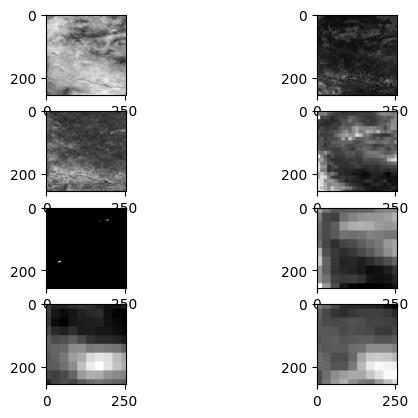

In [11]:
training = get_training_dataset('gs://' + DATA_BUCKET + '/' + FOLDER + '/' + TRAINING_BASE + '*')

In [12]:
def get_eval_dataset(filename_pattern):
	"""Get the preprocessed evaluation dataset
  Returns:
    A tf.data.Dataset of evaluation data.
  """
	dataset = get_dataset(filename_pattern)
	dataset = dataset.batch(1).repeat()
	return dataset

In [13]:
evaluation = get_eval_dataset('gs://' + DATA_BUCKET + '/' + FOLDER + '/' + EVAL_BASE + '*')

get_dataset:parse step1 <TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Parsed features: {'LST_Day_1km': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:0' shape=(256, 256) dtype=float32>, 'Lai': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:1' shape=(256, 256) dtype=float32>, 'NDVI': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:2' shape=(256, 256) dtype=float32>, 'SoilMoi00_10cm_tavg': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:3' shape=(256, 256) dtype=float32>, 'T21': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:4' shape=(256, 256) dtype=float32>, 'total_precipitation': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:5' shape=(256, 256) dtype=float32>, 'u_component_of_wind_10m': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:6' shape=(256, 256) dtype=float32>, 'v_component_of_wind_10m': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:7' shape=(256, 

unet

In [ ]:
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.models as models
import tensorflow.keras.metrics as metrics
import tensorflow.keras.optimizers as optimizers

def conv_block(input_tensor, num_filters):
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	return encoder

def encoder_block(input_tensor, num_filters):
	encoder = conv_block(input_tensor, num_filters)
	encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
	return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
	decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
	decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	return decoder

def get_model():
	inputs = layers.Input(shape=[None, None, len(BANDS)]) # 256
	encoder0_pool, encoder0 = encoder_block(inputs, 32) # 128
	encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
	encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
	encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
	encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
	center = conv_block(encoder4_pool, 1024) # center
	decoder4 = decoder_block(center, encoder4, 512) # 16
	decoder3 = decoder_block(decoder4, encoder3, 256) # 32
	decoder2 = decoder_block(decoder3, encoder2, 128) # 64
	decoder1 = decoder_block(decoder2, encoder1, 64) # 128
	decoder0 = decoder_block(decoder1, encoder0, 32) # 256
	outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

	model = models.Model(inputs=[inputs], outputs=[outputs])

	model.compile(
		optimizer=optimizers.get(OPTIMIZER),
		loss=losses.get(LOSS),
		metrics=[metrics.get(metric) for metric in METRICS],
		run_eagerly=True
		)

	return model

sanity check

In [ ]:
# Sizes of the training and evaluation datasets.
TRAIN_SIZE = 16000
EVAL_SIZE = 8000
BATCH_SIZE = 64

# BATCH_SIZE = 1
# TRAIN_SIZE = 8
# EVAL_SIZE = 8

print(type(training))
print(EPOCHS)
print(TRAIN_SIZE)
print(BATCH_SIZE)
print(int(TRAIN_SIZE / BATCH_SIZE))
# print(len(list(training)))
print(EVAL_SIZE)
# len(training)
# Check if GPU is available
if tf.test.is_gpu_available():
    # Get the list of available GPU devices
    gpu_devices = tf.config.experimental.list_physical_devices('GPU')
    if gpu_devices:
        # Print the name of the first GPU device
        print("Using GPU:", gpu_devices[0].name)
    else:
        print("No GPU devices available.")
print("Available GPU devices:")
print(tf.config.list_physical_devices('GPU'))
print("Current device used for computation:")
print(tf.config.list_logical_devices('GPU'))

In [ ]:
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

modular programming: make sure everything right before training

In [ ]:
stop

model training visualization

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

class TQDMCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_epochs):
        super(TQDMCallback, self).__init__()
        self.total_epochs = total_epochs
        self.pbar = tqdm(total=self.total_epochs, unit='epoch')

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.update(1)
        self.pbar.set_description(f"Epoch {epoch + 1}/{self.total_epochs}, Loss: {logs['loss']:.4f}, "
                                  f"RMSE: {logs['root_mean_squared_error']:.4f}, ")
                                  # f"Val_Loss: {logs['val_loss']:.4f}, "
                                  # f"Val_RMSE: {logs['val_root_mean_squared_error']:.4f}")

    def on_train_end(self, logs=None):
        self.pbar.close()
tqdm_callback = TQDMCallback(total_epochs=EPOCHS)

In [ ]:
m = get_model()

see model parameter

In [ ]:
m.summary()

In [ ]:
history = m.fit(
    x=training,
    epochs=10,
    steps_per_epoch=int(TRAIN_SIZE / BATCH_SIZE),
    validation_data=evaluation,
    validation_steps=EVAL_SIZE,
    callbacks=[tqdm_callback],
)

save model

In [ ]:
m.save('saved_model.h5')
from tensorflow.keras.models import load_model
# m = load_model('saved_model.h5')

In [ ]:
print(history.params)
print(history.history.keys())

visualize

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
batch_size = 64


ev = evaluation.take(100)
# Predict on the evaluation dataset with the specified number of steps
predictions = m.predict(x=ev)

In [ ]:
print(len(predictions[0]))
print(len(predictions[0][0]))

In [ ]:
threshold = 0.5
predicted_labels = np.where(predictions > threshold, 1, 0)

true_labels = np.array([label for _, label in ev])

accuracy = np.sum(predicted_labels == true_labels) / (len(true_labels) * 256*256)
print(f'Accuracy: {accuracy:.2f}')

In [ ]:
# # Load a trained model. 50 epochs. 25 hours. Final RMSE ~0.08.
# MODEL_DIR = 'gs://ee-docs-demos/fcnn-demo/trainer/model'
# m = tf.keras.models.load_model(MODEL_DIR)
# m.summary()

select image to export

In [ ]:
# print(featureStack.bandNames().getInfo())

In [ ]:
feature_img_lists = []
date_start_str = '2019-07-01'
pred_start = ee.Date(date_start_str)
pred_end = pred_start.advance(4, 'week')

for feature in feature_list:
  img_col = getImageCollection(feature['name'],pred_region_geometry, feature['band'])
  pred_img = img_col.filterDate(pred_start, pred_end).median().unitScale(feature['min'], feature['max'])
  feature_img_lists += [pred_img]
print(feature_img_lists)

In [ ]:
predict_image = feature_img_lists[0]
for idx in range(1, len(feature_img_lists)):
  # Combine all bands sampled from the same time to featureStack
  predict_image = ee.Image.cat([predict_image, feature_img_lists[idx]]).float()
# predict_image

In [ ]:
def doExport(predict_image, out_file_name, kernel_buffer, region):
    """Run the image export task.  Block until complete.
    """
    # Define the export task using the Earth Engine Python API.
    task = ee.batch.Export.image.toCloudStorage(
        image=predict_image,  # Select specific bands from the 'featureStack' Image.
        description=out_file_name,  # Description for the export task.
        bucket=OUTPUT_BUCKET,  # The destination Cloud Storage bucket.
        fileNamePrefix=FOLDER + '/' + out_file_name,  # File name prefix for the exported images.
        region=region.getInfo()['coordinates'],  # The bounding region for the export task.
        scale=SAMPLE_RESOLUTION,  # The spatial resolution in meters for the exported images.
        fileFormat='TFRecord',  # File format for the exported images (TensorFlow Record).
        maxPixels=1e10,  # Maximum number of pixels allowed for the export task.
        formatOptions={
            'patchDimensions': KERNEL_SHAPE,  # Dimensions of the image patches for segmentation.
            'kernelSize': kernel_buffer,  # Size of the kernel buffer for segmentation.
            'compressed': True,  # Enable compression for the exported images.
            'maxFileSize': 104857600  # Maximum file size for each exported image in bytes.
        }
    )
    print(FOLDER + '/' + out_file_name)
    # Start the export task.
    task.start()

    # Block until the task completes.
    print('Running image export to Cloud Storage...')
    import time
    while task.active():
        print('Polling for task (id: {}).'.format(task.id))
        time.sleep(30)

    # Check if the export task encountered an error.
    if task.status()['state'] != 'COMPLETED':
        print(f"Error with image export {task.status()['state']}")
    else:
        print('Image export completed.')

In [ ]:
doExport(predict_image, out_file_name, kernel_size, pred_region)

**!remember to change user_folder to your own GEE username**

In [ ]:
# def doPrediction(out_image_base, in_image_bucket, out_image_bucket, user_folder, kernel_buffer):
#   """Perform inference on exported imagery, upload to Earth Engine.
#   """

#   print('Looking for TFRecord files...')

#   # Get a list of all the files in the output bucket.
#   filesList = !gsutil ls 'gs://'{in_image_bucket}'/'{FOLDER}

#   # Get only the files generated by the image export.
#   exportFilesList = [s for s in filesList if out_image_base in s]

#   # Get the list of image files and the JSON mixer file.
#   imageFilesList = []
#   jsonFile = None
#   for f in exportFilesList:
#     if f.endswith('.tfrecord.gz'):
#       imageFilesList.append(f)
#     elif f.endswith('.json'):
#       jsonFile = f

#   # Make sure the files are in the right order.
#   imageFilesList.sort()

#   from pprint import pprint
#   pprint(imageFilesList)
#   print(jsonFile)

#   import json
#   # Load the contents of the mixer file to a JSON object.
#   jsonText = !gsutil cat {jsonFile}
#   # Get a single string w/ newlines from the IPython.utils.text.SList
#   mixer = json.loads(jsonText.nlstr)
#   pprint(mixer)
#   patches = mixer['totalPatches']

#   # Get set up for prediction.
#   x_buffer = int(kernel_buffer[0] / 2)
#   y_buffer = int(kernel_buffer[1] / 2)

#   buffered_shape = [
#       KERNEL_SHAPE[0] + kernel_buffer[0],
#       KERNEL_SHAPE[1] + kernel_buffer[1]]

#   imageColumns = [
#     tf.io.FixedLenFeature(shape=buffered_shape, dtype=tf.float32)
#       for k in BANDS
#   ]

#   imageFeaturesDict = dict(zip(BANDS, imageColumns))

#   def parse_image(example_proto):
#     return tf.io.parse_single_example(example_proto, imageFeaturesDict)

#   def toTupleImage(inputs):
#     inputsList = [inputs.get(key) for key in BANDS]
#     stacked = tf.stack(inputsList, axis=0)
#     stacked = tf.transpose(stacked, [1, 2, 0])
#     return stacked

#    # Create a dataset from the TFRecord file(s) in Cloud Storage.
#   imageDataset = tf.data.TFRecordDataset(imageFilesList, compression_type='GZIP')
#   imageDataset = imageDataset.map(parse_image, num_parallel_calls=5)
#   imageDataset = imageDataset.map(toTupleImage).batch(1)

#   # Perform inference.
#   print('Running predictions...')
#   predictions = m.predict(imageDataset, steps=patches, verbose=1)
#   # print(predictions[0])

#   print('Writing predictions...')
#   out_image_file = 'gs://' + out_image_bucket + '/' + FOLDER + '/' + out_image_base  + '.TFRecord'
#   writer = tf.io.TFRecordWriter(out_image_file)
#   patches = 0
#   for predictionPatch in predictions:
#     print('Writing patch ' + str(patches) + '...')
#     predictionPatch = predictionPatch[
#         x_buffer:x_buffer+KERNEL_SIZE, y_buffer:y_buffer+KERNEL_SIZE]

#     # Create an example.
#     example = tf.train.Example(
#       features=tf.train.Features(
#         feature={
#           'impervious': tf.train.Feature(
#               float_list=tf.train.FloatList(
#                   value=predictionPatch.flatten()))
#         }
#       )
#     )
#     # Write the example.
#     writer.write(example.SerializeToString())
#     patches += 1

#   writer.close()

#   # Start the upload.
#   out_image_asset = user_folder + '/' + out_image_base 
#   !earthengine upload image --asset_id={out_image_asset} {out_image_file} {jsonFile}

for debug(change to your own username)

In [ ]:
user_folder = 'users/jindacz' # INSERT YOUR FOLDER HERE.
pred_kernel_buffer = [128, 128]
# date_start_str = '2019-07-01'
out_file_name = f'pred_Hanceville_{date_start_str}'
pred_region = ee.Geometry.Polygon(
    [[[-120.09501953125, 53.81667309827828], 
    [-120.09501953125, 56.69527587549462], 
    [-125.76396484375, 56.69527587549462],     
    [-125.76396484375, 53.81667309827828]]],  None, False)
FOLDER = 'fcnn-demo'

def doPrediction(out_image_base, user_folder, kernel_buffer, region):
  """Perform inference on exported imagery, upload to Earth Engine.
  """

  print('Looking for TFRecord files...')

  # Get a list of all the files in the output bucket.
  filesList = !gsutil ls 'gs://'{OUTPUT_BUCKET}'/'{FOLDER}

  # Get only the files generated by the image export.
  exportFilesList = [s for s in filesList if out_image_base in s]

  # Get the list of image files and the JSON mixer file.
  imageFilesList = []
  jsonFile = None
  for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f)
    elif f.endswith('.json'):
      jsonFile = f

  # Make sure the files are in the right order.
  imageFilesList.sort()

  from pprint import pprint
  pprint(f'imageFilesList {imageFilesList}')
  # print(f'jsonFile {jsonFile}')

  import json
  # Load the contents of the mixer file to a JSON object.
  jsonText = !gsutil cat {jsonFile}
  # print(f'jsonText{jsonText}')
  # Get a single string w/ newlines from the IPython.utils.text.SList
  mixer = json.loads(jsonText.nlstr)
  pprint(mixer)
  patches = mixer['totalPatches']

  # Get set up for prediction.
  x_buffer = int(kernel_buffer[0] / 2)
  y_buffer = int(kernel_buffer[1] / 2)

  buffered_shape = [
      KERNEL_SHAPE[0] + kernel_buffer[0],
      KERNEL_SHAPE[1] + kernel_buffer[1]]

  imageColumns = [
    tf.io.FixedLenFeature(shape=buffered_shape, dtype=tf.float32)
      for k in BANDS
  ]

  imageFeaturesDict = dict(zip(BANDS, imageColumns))

  def parse_image(example_proto):
    return tf.io.parse_single_example(example_proto, imageFeaturesDict)

  def toTupleImage(inputs):
    inputsList = [inputs.get(key) for key in BANDS]
    stacked = tf.stack(inputsList, axis=0)
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked

   # Create a dataset from the TFRecord file(s) in Cloud Storage.
  imageDataset = tf.data.TFRecordDataset(imageFilesList, compression_type='GZIP')
  imageDataset = imageDataset.map(parse_image, num_parallel_calls=5)
  imageDataset = imageDataset.map(toTupleImage).batch(1)

  # Perform inference.
  print('Running predictions...')
  predictions = m.predict(imageDataset, steps=patches, verbose=1)
  # print(predictions[0])

  print('Writing predictions...')
  # out_image_base = 'shufeitest123'
  out_image_file = 'gs://' + OUTPUT_BUCKET + '/' + FOLDER + '/' + out_image_base + '.TFRecord'
  
  print(out_image_file)
  writer = tf.io.TFRecordWriter(out_image_file)
  patches = 0
    
  for predictionPatch in predictions:
    
    print('Writing patch ' + str(patches) + '...')
    predictionPatch = predictionPatch[
        x_buffer:x_buffer+KERNEL_SIZE, y_buffer:y_buffer+KERNEL_SIZE]
    
    # print(f'prediction patch {predictionPatch}')
    # Create an example.
    example = tf.train.Example(
      features=tf.train.Features(
        feature={
          'impervious': tf.train.Feature(
              float_list=tf.train.FloatList(
                  value=predictionPatch.flatten()))
        }
      )
    )
    # Write the example.
    writer.write(example.SerializeToString())
    print('finish writing patch ' + str(patches) + '...')
    patches += 1


  #writer.close()
  print(f'fin writing')

  # Start the upload.
  out_image_asset = user_folder + '/' + out_image_base
  !earthengine upload image --asset_id={out_image_asset} {out_image_file} {jsonFile}

# Run the prediction.
doPrediction(out_file_name, user_folder, pred_kernel_buffer, pred_region)

In [ ]:
# !python -m pip install tensorflow-io 
# !python -m pip uninstall -y tensorflow-io

In [ ]:
# doPrediction(out_file_name, OUTPUT_BUCKET, DATA_BUCKET, FOLDER, kernel_size)

In [ ]:
# # Run the prediction.
print(user_folder)
print(out_file_name)

In [ ]:
# out_image = ee.Image(user_folder + '/' + bj_image_base)
out_image = ee.Image(user_folder + '/' + out_file_name)
mapid = out_image.getMapId({'min': 0, 'max': 1})
map = folium.Map(location=[53.81667309827828, -120.09501953125])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='predicted impervious',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

export prediction to CSV

In [ ]:
pred_values = out_image.reduceRegion(
    reducer=ee.Reducer.toList(),
    geometry=pred_region,
    scale=926.625433055833,  # The scale from the image's 'crs_transform'
)

impervious_list = pred_values.get('impervious').getInfo()

# Convert the list of pixel values to a pandas DataFrame
df = pd.DataFrame(impervious_list, columns=['prediction'])

# Save the DataFrame as a CSV file
df.to_csv('prediction_results.csv', index=False)

In [ ]:
print(pred_values.get('impervious'))